# Predicting Fitness Class Attendance with Machine Learning  

In this notebook, we develop a machine learning pipeline to predict whether a fitness club member will attend a booked class.  

Missed bookings are a common issue for fitness centers — classes are often fully booked but many members fail to show up. By predicting attendance behavior, the club can **free up more spots, optimize capacity, and improve member experience**.  

This notebook walks through the complete ML workflow:
- **Data Preparation**: Cleaning raw data, handling missing values, encoding categorical features.  
- **Feature Engineering**: Creating meaningful variables such as booking urgency, weekend classes, and member tenure categories.  
- **Exploratory Analysis**: Understanding attendance patterns across categories, time, and booking behavior.  
- **Modeling**: Training and evaluating multiple models (Logistic Regression, Decision Tree, Random Forest, Gradient Boosting).  
- **Model Comparison**: Using ROC-AUC and cross-validation to identify the best model.  
- **Feature Importance**: Explaining model predictions through feature importances and coefficients.  

The end goal is to **build a predictive model that helps the club anticipate attendance** and make smarter decisions about booking policies.

In [52]:
# Import Libraries and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

## Data Loading and Initial Exploration  
Load the dataset and perform a quick inspection of its structure, columns, and basic statistics.  
We also check the target variable distribution (`attended`) to understand the baseline class balance.


In [53]:
# Load Data and Quick Overview

# Load the dataset
df = pd.read_csv('fitness_class_2212.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
display(df.head())

print("\nBasic info:")
print(df.info())

print(f"\nTarget variable distribution:")
print(df['attended'].value_counts())
print(f"Attendance rate: {df['attended'].mean():.2%}")

Dataset shape: (1500, 8)
Columns: ['booking_id', 'months_as_member', 'weight', 'days_before', 'day_of_week', 'time', 'category', 'attended']

First few rows:


,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0



Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB
None

Target variable distribution:
attended
0    1046
1     454
Name: count, dtype: int64
Attendance rate: 30.27%


## Data Cleaning and Preprocessing  
- Handle missing values (e.g., filling missing weights).  
- Clean and convert booking lead time (`days_before`).  
- Encode categorical variables (`day_of_week`, `time`, `category`).  
This step ensures the dataset is ready for modeling.


In [54]:
# Data Cleaning and Preprocessing

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Clean days_before column (remove text, convert to numeric)
df['days_before_clean'] = df['days_before'].str.extract('(\d+)').astype(int)
print(f"\nDays before - original vs cleaned:")
print(f"Original: {df['days_before'].head().tolist()}")
print(f"Cleaned: {df['days_before_clean'].head().tolist()}")

# Handle missing weights with median
df['weight'].fillna(df['weight'].median(), inplace=True)

# Create binary encodings for categorical variables
le_day = LabelEncoder()
le_time = LabelEncoder()
le_category = LabelEncoder()

df['day_encoded'] = le_day.fit_transform(df['day_of_week'])
df['time_encoded'] = le_time.fit_transform(df['time'])
df['category_encoded'] = le_category.fit_transform(df['category'])

print(f"\nEncoded mappings:")
print(f"Days: {dict(zip(le_day.classes_, le_day.transform(le_day.classes_)))}")
print(f"Time: {dict(zip(le_time.classes_, le_time.transform(le_time.classes_)))}")
print(f"Category: {dict(zip(le_category.classes_, le_category.transform(le_category.classes_)))}")

print(f"\nDataset shape after preprocessing: {df.shape}")
display(df[['months_as_member', 'weight', 'days_before_clean', 'day_encoded', 'time_encoded', 'category_encoded', 'attended']].head())

Missing values:
booking_id           0
months_as_member     0
weight              20
days_before          0
day_of_week          0
time                 0
category             0
attended             0
dtype: int64

Days before - original vs cleaned:
Original: ['8', '2', '14', '10', '8']
Cleaned: [8, 2, 14, 10, 8]

Encoded mappings:
Days: {'Fri': np.int64(0), 'Fri.': np.int64(1), 'Mon': np.int64(2), 'Monday': np.int64(3), 'Sat': np.int64(4), 'Sun': np.int64(5), 'Thu': np.int64(6), 'Tue': np.int64(7), 'Wed': np.int64(8), 'Wednesday': np.int64(9)}
Time: {'AM': np.int64(0), 'PM': np.int64(1)}
Category: {'-': np.int64(0), 'Aqua': np.int64(1), 'Cycling': np.int64(2), 'HIIT': np.int64(3), 'Strength': np.int64(4), 'Yoga': np.int64(5)}

Dataset shape after preprocessing: (1500, 12)


,months_as_member,weight,days_before_clean,day_encoded,time_encoded,category_encoded,attended
0,17,79.56,8,8,1,4,0
1,10,79.01,2,2,0,3,0
2,16,74.53,14,5,0,4,0
3,5,86.12,10,0,0,2,0
4,15,69.29,8,6,0,3,0


## Feature Engineering and Exploratory Analysis  
Introduce new features to capture patterns in member behavior:  
- Weekend vs weekday  
- Morning vs evening classes  
- Member tenure categories  
- Booking urgency  

We also visualize attendance patterns across categories, days, and booking behaviors to extract insights.


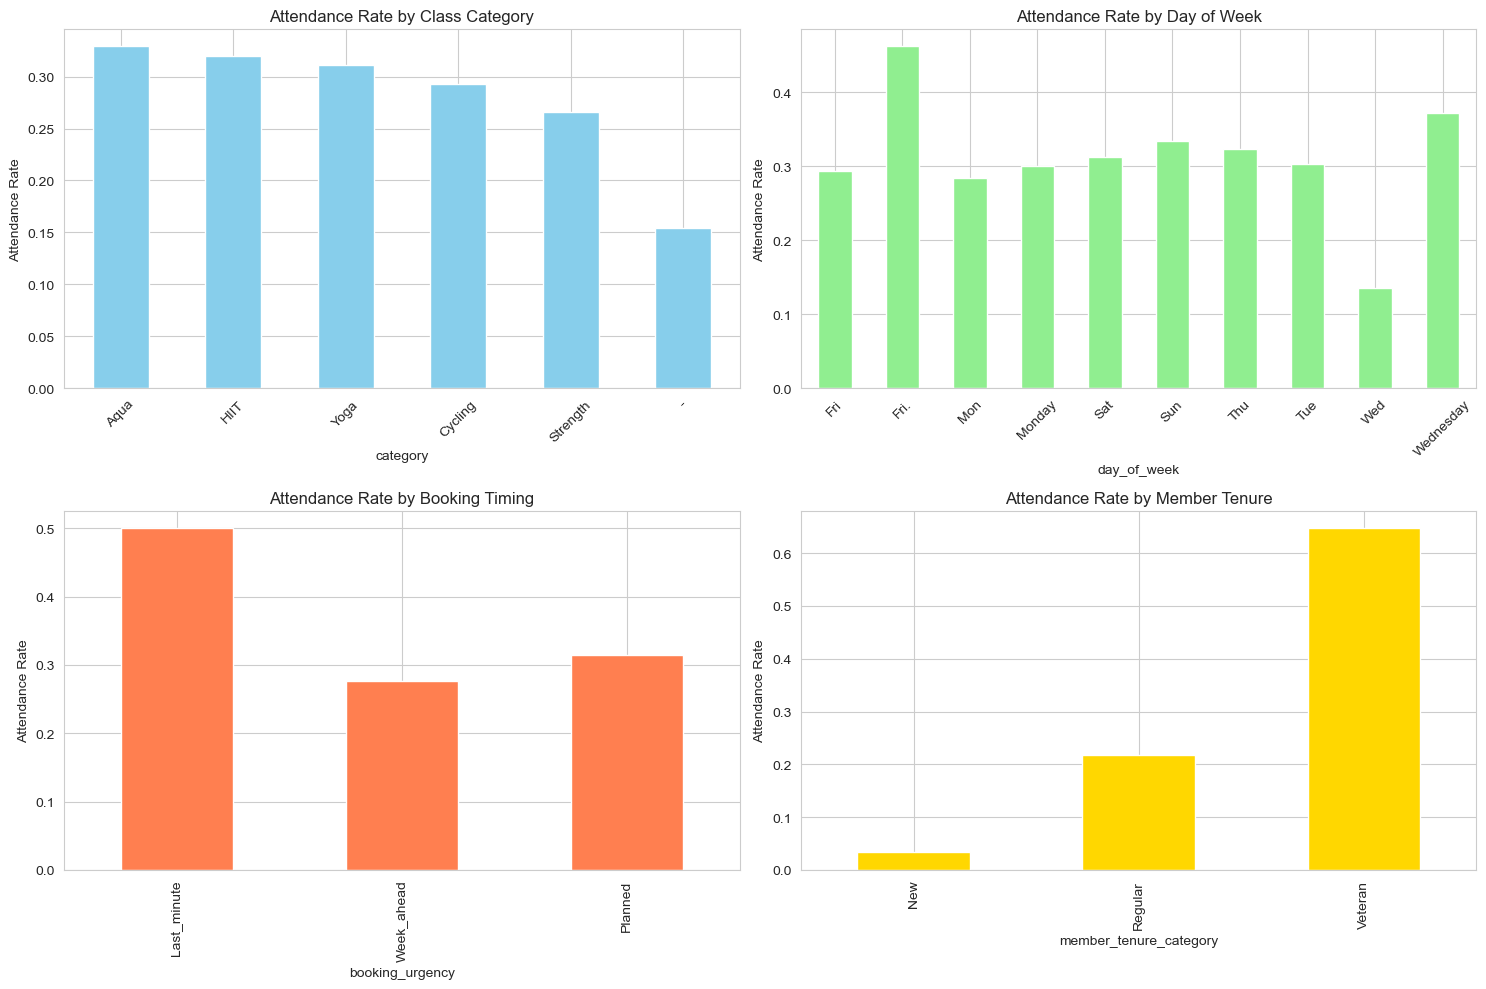

Key insights:
Highest attendance: Aqua (32.89%)
Lowest attendance: - (15.38%)
Weekend vs Weekday attendance: [0.29493088 0.32289157]
AM vs PM attendance: [0.26183844 0.31551271]


In [55]:
# Feature Engineering and EDA

# Create additional features
df['is_weekend'] = df['day_of_week'].isin(['Sat', 'Sun']).astype(int)
df['is_morning'] = (df['time'] == 'AM').astype(int)
df['member_tenure_category'] = pd.cut(df['months_as_member'], 
                                    bins=[0, 6, 18, float('inf')], 
                                    labels=['New', 'Regular', 'Veteran'])
df['booking_urgency'] = pd.cut(df['days_before_clean'], 
                             bins=[0, 1, 7, float('inf')], 
                             labels=['Last_minute', 'Week_ahead', 'Planned'])

# Quick visualization of key patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Attendance by category
cat_attend = df.groupby('category')['attended'].mean().sort_values(ascending=False)
cat_attend.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Attendance Rate by Class Category')
axes[0,0].set_ylabel('Attendance Rate')
axes[0,0].tick_params(axis='x', rotation=45)

# Attendance by day of week
day_attend = df.groupby('day_of_week')['attended'].mean()
day_attend.plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Attendance Rate by Day of Week')
axes[0,1].set_ylabel('Attendance Rate')
axes[0,1].tick_params(axis='x', rotation=45)

# Attendance by booking urgency
urgency_attend = df.groupby('booking_urgency')['attended'].mean()
urgency_attend.plot(kind='bar', ax=axes[1,0], color='coral')
axes[1,0].set_title('Attendance Rate by Booking Timing')
axes[1,0].set_ylabel('Attendance Rate')

# Member tenure vs attendance
tenure_attend = df.groupby('member_tenure_category')['attended'].mean()
tenure_attend.plot(kind='bar', ax=axes[1,1], color='gold')
axes[1,1].set_title('Attendance Rate by Member Tenure')
axes[1,1].set_ylabel('Attendance Rate')

plt.tight_layout()
plt.show()

print("Key insights:")
print(f"Highest attendance: {cat_attend.index[0]} ({cat_attend.iloc[0]:.2%})")
print(f"Lowest attendance: {cat_attend.index[-1]} ({cat_attend.iloc[-1]:.2%})")
print(f"Weekend vs Weekday attendance: {df.groupby('is_weekend')['attended'].mean().values}")
print(f"AM vs PM attendance: {df.groupby('is_morning')['attended'].mean().values}")

## Feature Selection and Correlation  
Select the most relevant features for modeling.  
Visualize feature correlations with the target and among predictors to spot strong relationships or redundancies.


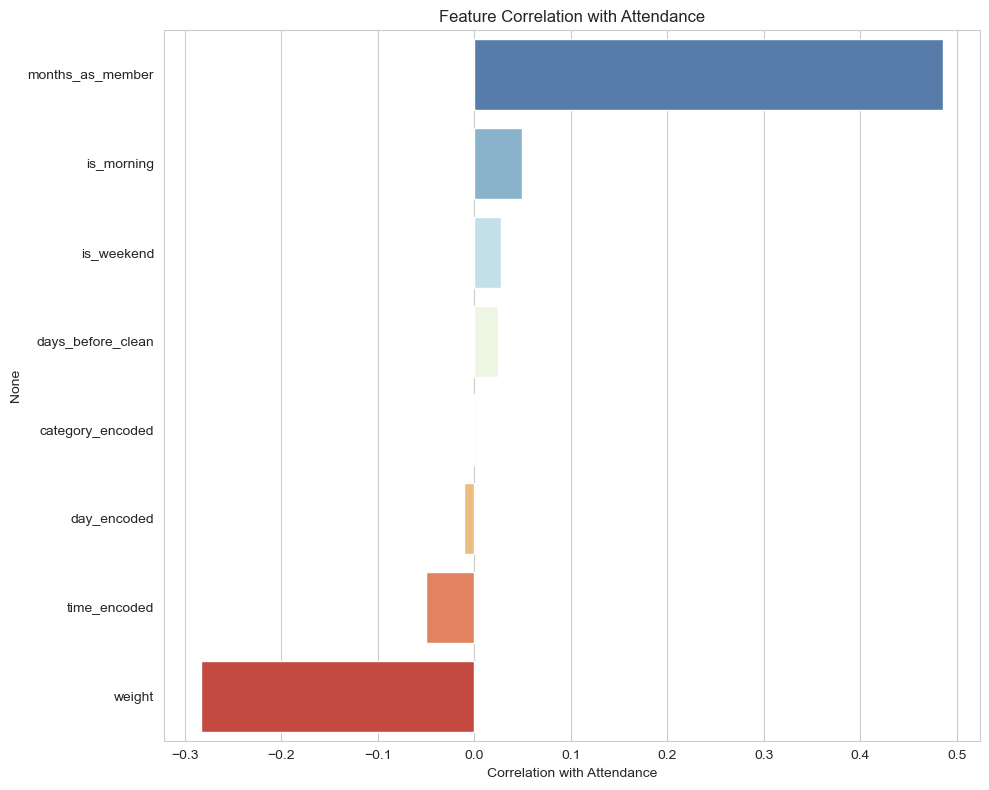

Feature correlations with attendance:
months_as_member: 0.4855
is_morning: 0.0498
is_weekend: 0.0272
days_before_clean: 0.0241
category_encoded: -0.0009
day_encoded: -0.0109
time_encoded: -0.0498
weight: -0.2833


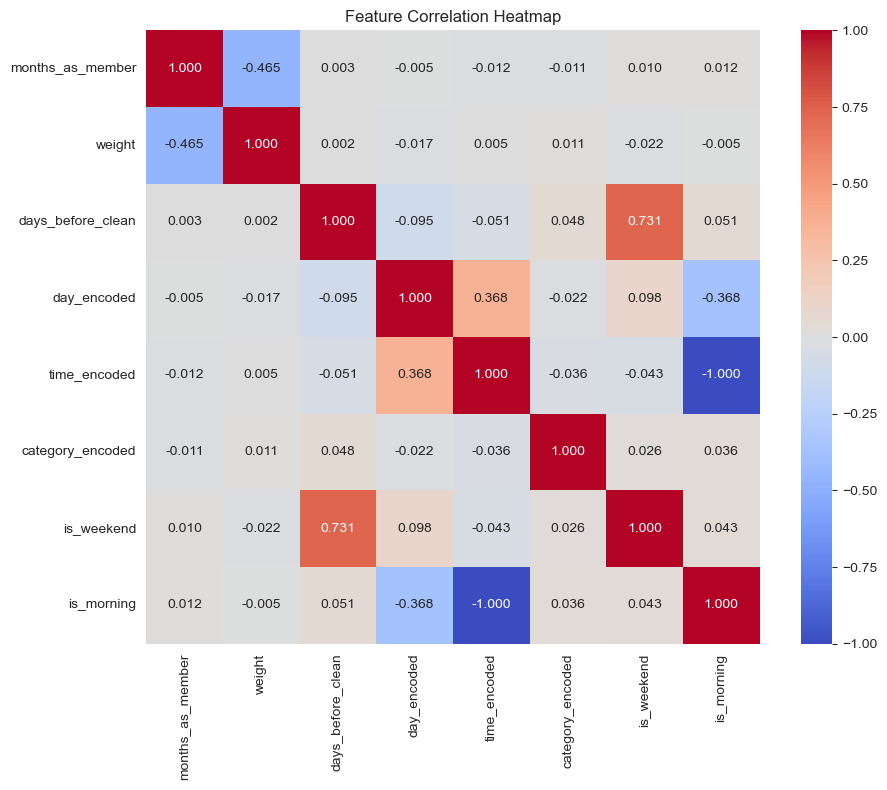


Feature matrix shape: (1500, 8)
Target distribution: {0: 1046, 1: 454}


In [56]:
# Feature Selection and Correlation Analysis

# Select features for modeling
feature_cols = ['months_as_member', 'weight', 'days_before_clean', 'day_encoded', 
                'time_encoded', 'category_encoded', 'is_weekend', 'is_morning']

X = df[feature_cols].copy()
y = df['attended'].copy()

# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = X.corrwith(y).sort_values(ascending=False)
sns.barplot(x=correlation_matrix.values, y=correlation_matrix.index, palette='RdYlBu_r')
plt.title('Feature Correlation with Attendance')
plt.xlabel('Correlation with Attendance')
plt.tight_layout()
plt.show()

print("Feature correlations with attendance:")
for feature, corr in correlation_matrix.items():
    print(f"{feature}: {corr:.4f}")

# Feature correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

## Train-Test Split and Scaling  
Split the dataset into training and test sets (stratified).  
Scale numerical features for algorithms sensitive to magnitude (e.g., Logistic Regression).  
This ensures fair evaluation and consistent feature distributions.


In [57]:
# Train-Test Split and Data Scaling

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set attendance rate: {y_train.mean():.2%}")
print(f"Test set attendance rate: {y_test.mean():.2%}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nFeature scaling completed")
print("Sample scaled features (first 5 rows):")
print(X_train_scaled.head())
        

Training set shape: (1200, 8)
Test set shape: (300, 8)
Training set attendance rate: 30.25%
Test set attendance rate: 30.33%

Feature scaling completed
Sample scaled features (first 5 rows):
   months_as_member    weight  days_before_clean  day_encoded  time_encoded  \
0          2.788382 -1.042080           0.400859    -1.542395     -0.565802   
1          0.338403 -0.128488          -1.550585    -0.787244     -0.565802   
2         -0.886586  0.325190          -1.062724     1.100632     -0.565802   
3         -0.733462  0.977644           0.888720    -0.032094     -0.565802   
4          0.261841  1.227089           0.400859    -1.542395     -0.565802   

   category_encoded  is_weekend  is_morning  
0          0.046203   -0.621032    0.565802  
1         -0.926501   -0.621032    0.565802  
2          0.046203   -0.621032    0.565802  
3          0.046203    1.610222    0.565802  
4         -0.926501   -0.621032    0.565802  


## Model Training and Comparison  
Train and evaluate multiple machine learning models:  
- Logistic Regression  
- Decision Tree  
- Random Forest  
- Gradient Boosting  

We use cross-validation and ROC-AUC to compare their performance.


In [58]:
# Model Training and Comparison

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Store results
results = {}
cv_scores = {}

print("Training models and performing cross-validation...")
print("=" * 50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for Logistic Regression, original for tree-based models
    if name == 'Logistic Regression':
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Train the model
    model.fit(X_train_model, y_train)
    
    # Cross-validation
    cv_score = cross_val_score(model, X_train_model, y_train, cv=5, scoring='roc_auc')
    cv_scores[name] = cv_score
    
    # Predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc,
        'cv_mean': cv_score.mean(),
        'cv_std': cv_score.std()
    }
    
    print(f"Cross-validation ROC-AUC: {cv_score.mean():.4f} (+/- {cv_score.std() * 2:.4f})")
    print(f"Test set ROC-AUC: {roc_auc:.4f}")

print("\n" + "=" * 50)
print("Model Comparison Summary:")
print("=" * 50)

for name in models.keys():
    print(f"{name}:")
    print(f"  CV ROC-AUC: {results[name]['cv_mean']:.4f} (+/- {results[name]['cv_std'] * 2:.4f})")
    print(f"  Test ROC-AUC: {results[name]['roc_auc']:.4f}")

Training models and performing cross-validation...

Training Logistic Regression...
Cross-validation ROC-AUC: 0.8140 (+/- 0.0473)
Test set ROC-AUC: 0.8162

Training Decision Tree...
Cross-validation ROC-AUC: 0.6330 (+/- 0.0417)
Test set ROC-AUC: 0.6527

Training Random Forest...
Cross-validation ROC-AUC: 0.7735 (+/- 0.0605)
Test set ROC-AUC: 0.7849

Training Gradient Boosting...
Cross-validation ROC-AUC: 0.7979 (+/- 0.0441)
Test set ROC-AUC: 0.7985

Model Comparison Summary:
Logistic Regression:
  CV ROC-AUC: 0.8140 (+/- 0.0473)
  Test ROC-AUC: 0.8162
Decision Tree:
  CV ROC-AUC: 0.6330 (+/- 0.0417)
  Test ROC-AUC: 0.6527
Random Forest:
  CV ROC-AUC: 0.7735 (+/- 0.0605)
  Test ROC-AUC: 0.7849
Gradient Boosting:
  CV ROC-AUC: 0.7979 (+/- 0.0441)
  Test ROC-AUC: 0.7985


## Model Evaluation and Metrics  
Perform a deeper evaluation of the best-performing model:  
- Classification report  
- Confusion matrix  
- ROC curves for all models  
- Cross-validation performance comparison  
This helps assess both accuracy and robustness.


Best performing model: Logistic Regression
CV ROC-AUC: 0.8140
Test ROC-AUC: 0.8162

Detailed evaluation for Logistic Regression:

Classification Report:
              precision    recall  f1-score   support

Not Attended       0.80      0.93      0.86       209
    Attended       0.75      0.48      0.59        91

    accuracy                           0.79       300
   macro avg       0.78      0.71      0.72       300
weighted avg       0.79      0.79      0.78       300



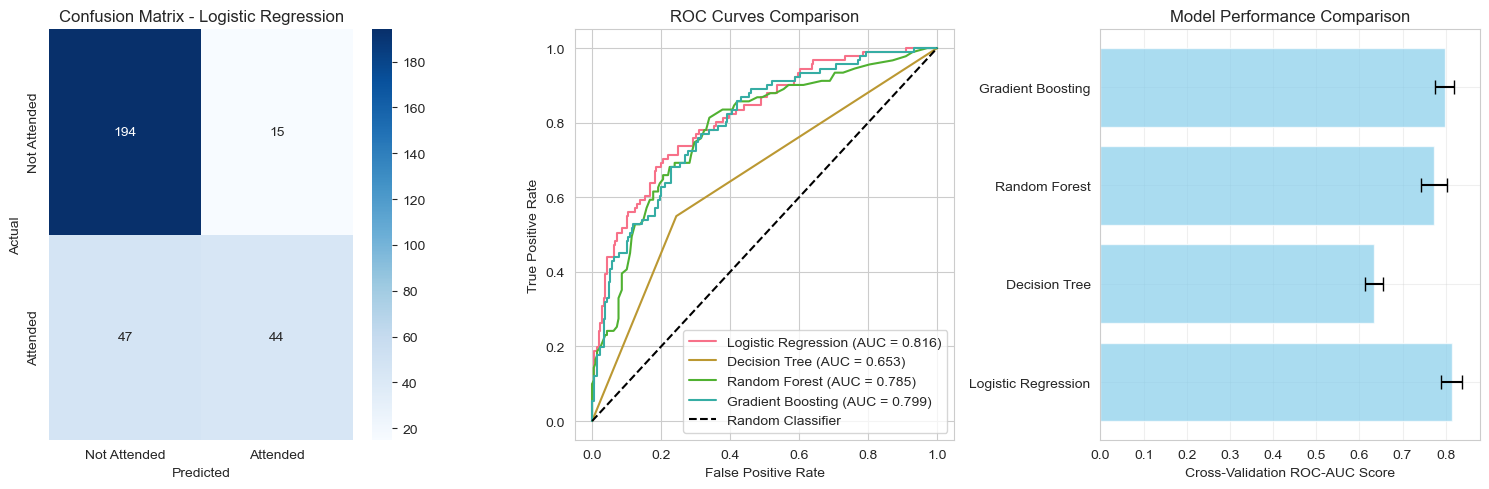

In [59]:
# Model Evaluation and Metrics

# Find best model based on cross-validation score
best_model_name = max(results.keys(), key=lambda x: results[x]['cv_mean'])
best_model = results[best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"CV ROC-AUC: {best_model['cv_mean']:.4f}")
print(f"Test ROC-AUC: {best_model['roc_auc']:.4f}")

# Detailed evaluation for best model
print(f"\nDetailed evaluation for {best_model_name}:")
print("=" * 50)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, best_model['y_pred'], 
                          target_names=['Not Attended', 'Attended']))

# Confusion Matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, best_model['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Attended', 'Attended'],
            yticklabels=['Not Attended', 'Attended'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curves for all models
plt.subplot(1, 3, 2)
for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Cross-validation scores comparison
plt.subplot(1, 3, 3)
model_names = list(models.keys())
cv_means = [results[name]['cv_mean'] for name in model_names]
cv_stds = [results[name]['cv_std'] for name in model_names]

plt.barh(model_names, cv_means, xerr=cv_stds, capsize=5, color='skyblue', alpha=0.7)
plt.xlabel('Cross-Validation ROC-AUC Score')
plt.title('Model Performance Comparison')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Feature Importance Analysis  
Examine which features drive predictions:  
- Tree-based models provide feature importance scores.  
- Logistic Regression coefficients highlight positive/negative effects.  

This step adds interpretability and connects predictions back to real-world behaviors.


Feature Importance Analysis

Decision Tree - Top 5 Important Features:
  1. months_as_member: 0.4021
  2. weight: 0.3650
  3. category_encoded: 0.0835
  4. days_before_clean: 0.0828
  5. day_encoded: 0.0379

Random Forest - Top 5 Important Features:
  1. months_as_member: 0.3901
  2. weight: 0.3697
  3. category_encoded: 0.0847
  4. days_before_clean: 0.0734
  5. day_encoded: 0.0578

Gradient Boosting - Top 5 Important Features:
  1. months_as_member: 0.6897
  2. weight: 0.2160
  3. days_before_clean: 0.0310
  4. day_encoded: 0.0258
  5. category_encoded: 0.0179

Logistic Regression - Feature Coefficients:
  months_as_member: 1.5431 (increases attendance probability)
  weight: -0.1463 (decreases attendance probability)
  is_weekend: 0.1026 (increases attendance probability)
  is_morning: 0.0478 (increases attendance probability)
  time_encoded: -0.0478 (decreases attendance probability)
  days_before_clean: -0.0377 (decreases attendance probability)
  day_encoded: 0.0095 (increases att

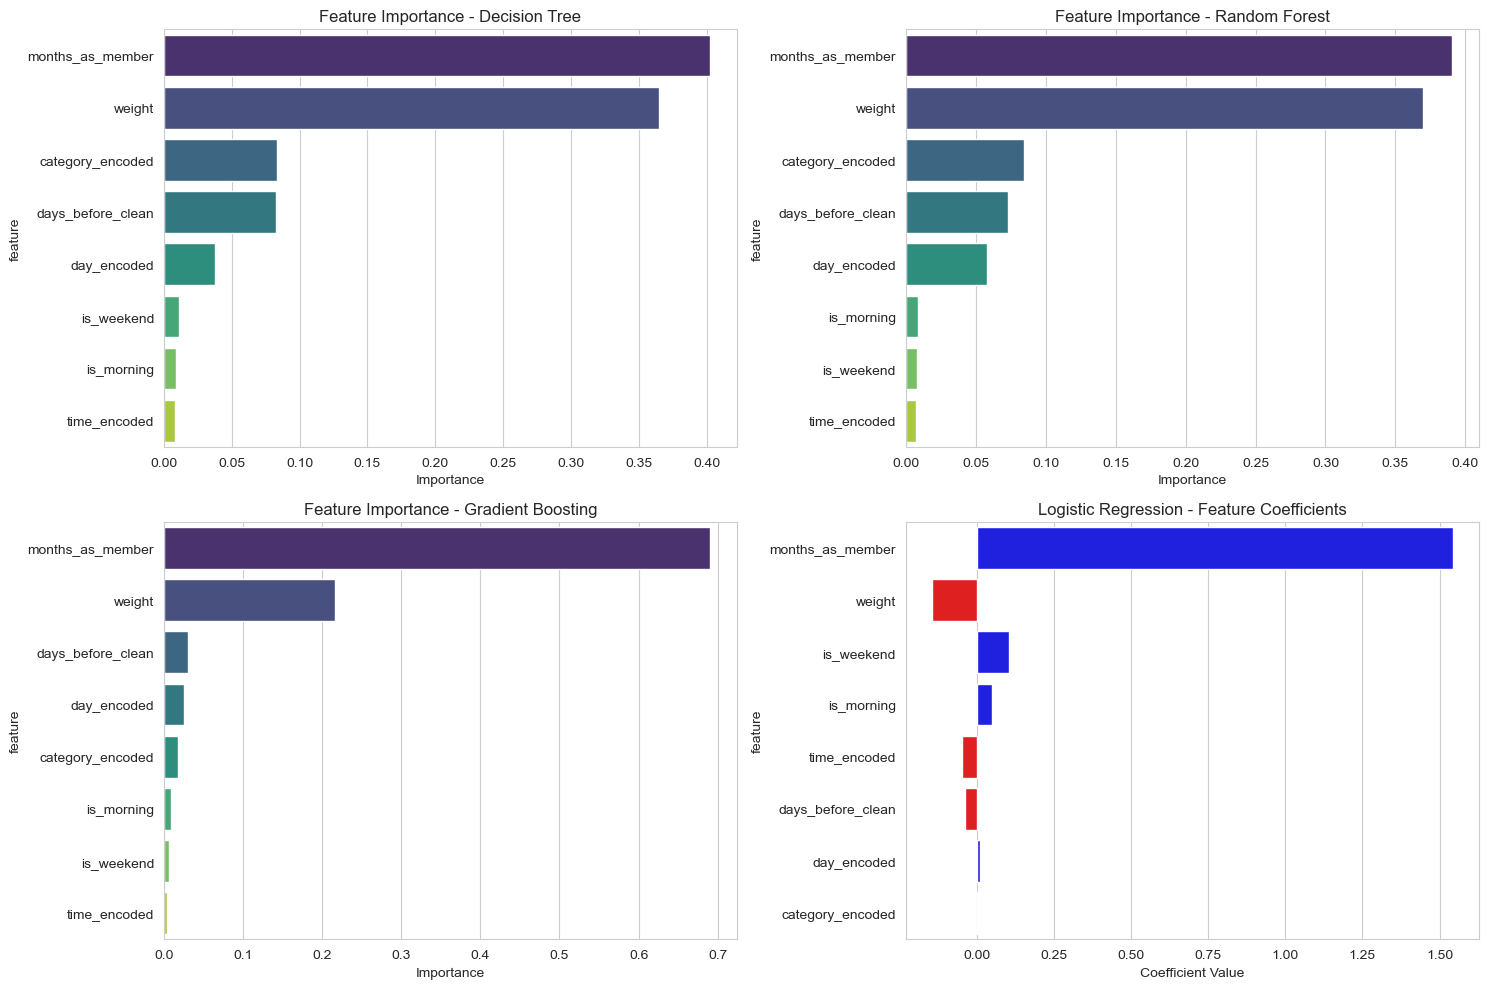


Overall insights:
- Best model: Logistic Regression with 0.816 ROC-AUC
- Class imbalance: 69.7% no-shows vs 30.3% attendance
- Model can predict attendance with moderate success


In [60]:
# Cell 9: Feature Importance Analysis

print("Feature Importance Analysis")
print("=" * 40)

# Get feature importance for tree-based models
tree_models = ['Decision Tree', 'Random Forest', 'Gradient Boosting']

plt.figure(figsize=(15, 10))

for i, model_name in enumerate(tree_models):
    if model_name in results:
        model = results[model_name]['model']
        importance = model.feature_importances_
        
        # Create feature importance dataframe
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        plt.subplot(2, 2, i+1)
        sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Importance')
        
        print(f"\n{model_name} - Top 5 Important Features:")
        for j, (idx, row) in enumerate(feature_importance.head().iterrows()):
            print(f"  {j+1}. {row['feature']}: {row['importance']:.4f}")

# Logistic Regression coefficients
if 'Logistic Regression' in results:
    lr_model = results['Logistic Regression']['model']
    coef_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': lr_model.coef_[0],
        'abs_coefficient': np.abs(lr_model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    plt.subplot(2, 2, 4)
    colors = ['red' if x < 0 else 'blue' for x in coef_importance['coefficient']]
    sns.barplot(data=coef_importance, x='coefficient', y='feature', palette=colors)
    plt.title('Logistic Regression - Feature Coefficients')
    plt.xlabel('Coefficient Value')
    
    print(f"\nLogistic Regression - Feature Coefficients:")
    for idx, row in coef_importance.iterrows():
        direction = "increases" if row['coefficient'] > 0 else "decreases"
        print(f"  {row['feature']}: {row['coefficient']:.4f} ({direction} attendance probability)")

plt.tight_layout()
plt.show()

print(f"\nOverall insights:")
print(f"- Best model: {best_model_name} with {best_model['roc_auc']:.3f} ROC-AUC")
print(f"- Class imbalance: {(y.value_counts()[0] / len(y)):.1%} no-shows vs {(y.value_counts()[1] / len(y)):.1%} attendance")
print(f"- Model can predict attendance with moderate success")